In [ ]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Beyond Single Runs: Tendency Analysis of Non-Deterministic Eval Tasks



<table align="left">

</table>

| | |
|-|-|
|Author(s) | [Alejandro Ballesta](https://www.linkedin.com/in/alejandroballestae/) |

**_NOTE_**: This notebook has been tested in the following environment:

* Python version = 3.9

## Overview

This notebook explores the application of statistical methods to gain insights into the behavior of the **Vertex AI Python SDK for Rapid Evaluation** for generated answers during **Question Answering** (QA) tasks. Due to the inherent variability, non-deterministic or probabilistic outcomes in these tasks, relying on a single execution may not provide a comprehensive understanding of the real performance.


We'll delve into techniques to aggregate and analyze results from multiple runs, enabling us to:
* **Identifying the problem:** running multiple tests over the same data to understand the non-deterministic outputs
* **Setting up a more reliable approach:** using the same pair of questions and contexts, we will use the generated answers of two different models (Gemini 1.5 vs Gemini Flash) as an input to our method and demonstrate an extensive methodology to derive better conclusions
* **Running the experiment:** for each model, we will run the QA RapidEval method 40 times to extract multiple performance metrics
* **Quantifying Performance:** we will calculate key statistical measures like mean, median, and standard deviation to gauge central tendency and variability across executions.
* **Identifying Performance:** In this section, using the statistical measures calculated, we will visualize the distributions of each metric overlapping the results of both models in the same chart
* **Assessing Confidence:** applying confidence intervals or hypothesis testing we will draw statistically sound conclusions about the performance of eval tasks.
By leveraging these statistical tools, we aim to move beyond single-run observations and gain a more robust understanding of the true behavior and capabilities of these non-deterministic tasks.
* **Comparing Results:** we will plot a radar chart and determine which model is better for our own goals

**Note:** The purpose of this analysis is not to have a completely statistical (since we are making a lot of assumptions) proof, but to gain a more holistic view of the architecture's performance


## Getting Started

### Install Vertex AI SDK for Rapid Evaluation

In [ ]:
%pip install --upgrade --user --quiet google-cloud-aiplatform[rapid_evaluation]
%pip install --quiet --upgrade nest_asyncio

### Restart runtime
To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which restarts the current kernel.

The restart might take a minute or longer. After it's restarted, continue to the next step.

In [ ]:
# import IPython

# app = IPython.Application.instance()
# app.kernel.do_shutdown(True)

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Wait until it's finished before continuing to the next step. ⚠️</b>
</div>


### Authenticate your notebook environment (Colab only)

In [ ]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user()

### Set Google Cloud project information and initialize Vertex AI SDK

In [ ]:
PROJECT_ID = "cloud-llm-preview1"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}


import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

### Import libraries

In [ ]:
# General
from IPython.display import display, Markdown, HTML
import logging
import nest_asyncio
import warnings

# Main
from vertexai.preview.evaluation import EvalTask
import pandas as pd

### Library settings

In [ ]:
logging.getLogger("urllib3.connectionpool").setLevel(logging.ERROR)
nest_asyncio.apply()
warnings.filterwarnings("ignore")

# **Identifying the problem**
In this section we are going to run 2 independent evaluation tasks and gather evidence of different results under the same following conditions:
* **Questions:** set of 5 random questions (same questions for each test)
* **Retrieved context:** for the purpose of this notebook we assume that the contex is retrieved with any particular method
* **Generated answers:** we are going to use the answers already presented on the RapidEval Getting Started notebook ([evaluate_rag_rapid_eval](https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/gemini/evaluation/evaluate_rag_rapid_evaluation_sdk.ipynb))


## Prepare Dataset

To evaluate the RAG generated answers, the evaluation dataset is required to contain the following fields:

* Question
* Context
* RAG Generated Answer

In [ ]:
questions = [
    "Which part of the brain does short-term memory seem to rely on?",
    "What provided the Roman senate with exuberance?",
    "What area did the Hasan-jalalians command?",
    "How many pencils could be made from the carbon in an average adult human body?"
]

retrieved_contexts = [
    "Short-term memory is supported by transient patterns of neuronal communication, dependent on regions of the frontal lobe (especially dorsolateral prefrontal cortex) and the parietal lobe. Long-term memory, on the other hand, is maintained by more stable and permanent changes in neural connections widely spread throughout the brain. The hippocampus is essential (for learning new information) to the consolidation of information from short-term to long-term memory, although it does not seem to store information itself. Without the hippocampus, new memories are unable to be stored into long-term memory, as learned from patient Henry Molaison after removal of both his hippocampi, and there will be a very short attention span. Furthermore, it may be involved in changing neural connections for a period of three months or more after the initial learning.",
    "In 62 BC, Pompey returned victorious from Asia. The Senate, elated by its successes against Catiline, refused to ratify the arrangements that Pompey had made. Pompey, in effect, became powerless. Thus, when Julius Caesar returned from a governorship in Spain in 61 BC, he found it easy to make an arrangement with Pompey. Caesar and Pompey, along with Crassus, established a private agreement, now known as the First Triumvirate. Under the agreement, Pompey's arrangements would be ratified. Caesar would be elected consul in 59 BC, and would then serve as governor of Gaul for five years. Crassus was promised a future consulship.",
    "The Seljuk Empire soon started to collapse. In the early 12th century, Armenian princes of the Zakarid noble family drove out the Seljuk Turks and established a semi-independent Armenian principality in Northern and Eastern Armenia, known as Zakarid Armenia, which lasted under the patronage of the Georgian Kingdom. The noble family of Orbelians shared control with the Zakarids in various parts of the country, especially in Syunik and Vayots Dzor, while the Armenian family of Hasan-Jalalians controlled provinces of Artsakh and Utik as the Kingdom of Artsakh.",
    "The average adult human body contains enough carbon to make about 900 pencils"
]

generated_answers = [
    "frontal lobe and the parietal lobe",
    "The Roman Senate was filled with exuberance due to successes against Catiline.",
    "The Hasan-Jalalians commanded the area of Syunik and Vayots Dzor.",
    "around 901"
]


eval_dataset = pd.DataFrame(
    {
        "prompt": questions,
        "context": retrieved_contexts,
        "response": generated_answers,
    }
)

## Select Metric and Define EvalTask


Choose from the following metrics for an evaluation task. For more information about the supported evaluation metrics and how to use each metric, please see [Evaluation methods and metrics](https://cloud.google.com/vertex-ai/generative-ai/docs/models/determine-eval).

*   `question_answering_quality` (overall quality)
*   `question_answering_relevance`
*   `question_answering_helpfulness`
*   `groundedness`
*   `fulfillment`

You can run evaluation for just one metric, or a combination of metrics. For example, we create an `EvalTask` named `answer_eval_task` with all the QA-related metrics to compute all the metrics in one eval run as follows:

In [ ]:
answer_eval_task = EvalTask(
    dataset=eval_dataset,
    metrics=[
        "question_answering_quality",
        "groundedness",
        "coherence",
        "fluency",
        "verbosity"
    ],
    experiment="rag-eval-01",
)

## Run Evaluation

In [ ]:
first_result = answer_eval_task.evaluate()
second_result = answer_eval_task.evaluate()

INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-eval-01-ce9879d6-c07a-4458-9f9e-23dcd563b3d1 to Experiment: rag-eval-01


INFO:vertexai.evaluation._evaluation:Computing metrics with a total of 20 Vertex online evaluation service requests.
100%|██████████| 20/20 [01:19<00:00,  3.98s/it]
INFO:vertexai.evaluation._evaluation:All 20 metric requests are successfully computed.
INFO:vertexai.evaluation._evaluation:Evaluation Took:79.72853652599997 seconds


INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-eval-01-9c47bef5-b98c-4004-93c2-ac7a9f371ef0 to Experiment: rag-eval-01


INFO:vertexai.evaluation._evaluation:Computing metrics with a total of 20 Vertex online evaluation service requests.
100%|██████████| 20/20 [01:19<00:00,  3.99s/it]
INFO:vertexai.evaluation._evaluation:All 20 metric requests are successfully computed.
INFO:vertexai.evaluation._evaluation:Evaluation Took:79.92863006800007 seconds


In [ ]:
first_result.summary_metrics

{'row_count': 4,
 'question_answering_quality/mean': 3.0,
 'question_answering_quality/std': 1.632993161855452,
 'groundedness/mean': 0.0,
 'groundedness/std': 0.0,
 'coherence/mean': 2.5,
 'coherence/std': 1.7320508075688772,
 'fluency/mean': 3.0,
 'fluency/std': 1.4142135623730951,
 'verbosity/mean': -0.75,
 'verbosity/std': 0.5}

#Let's compare the results of running the same experiment twice

In [ ]:
first_df = pd.DataFrame(first_result.metrics_table)
second_df = pd.DataFrame(second_result.metrics_table)

first_df = first_df.add_prefix('first_')
second_df = second_df.add_prefix('second_')

result = pd.concat([first_df, second_df], axis=1)
result[["first_question_answering_quality/score","second_question_answering_quality/score"]]


,first_question_answering_quality/score,second_question_answering_quality/score
0,3.0,3.0
1,3.0,2.0
2,5.0,5.0
3,1.0,2.0


You are probably seeing different results for at least one row; if not, try again
:)

# **Setting up a more reliable approach**

if you are comparing two differnt architectures (Ex, Gemini 1.5 generations vs Gemini Flash generations), it's recommended to use sample distributions to understand the perfomance of each approach.

Let's see one example


## Gemini 1.5 vs Gemini Flash set up

In [ ]:
generated_answers_gemini_1_5 = [
    "frontal lobe and the parietal lobe",
    "The Roman Senate was filled with exuberance due to successes against Catiline.",
    "The Hasan-Jalalians commanded the area of Syunik and Vayots Dzor.",
    "around 900 pencils could be made from an adult human body"
]

generated_answers_gemini_flash = [
    "frontal lobe",
    "The Roman Senate was filled with exuberance due to successes against Catiline.",
    "The Hasan-Jalalians commanded Vayots Dzor",
    "I would guess 901"
]

eval_dataset_gemini_1_5 = pd.DataFrame(
    {
        "prompt": questions,
        "context": retrieved_contexts,
        "response": generated_answers_gemini_1_5,
    }
)
eval_dataset_gemini_flash = pd.DataFrame(
    {
        "prompt": questions,
        "context": retrieved_contexts,
        "response": generated_answers_gemini_flash,
    }
)

#**Running the experiment**

Once the answers have been generated, let's run 40 identical experiments for each approach

In [ ]:
#Let's first define the metrics we are going to use

metrics = ["question_answering_quality",
        "groundedness",
        "coherence",
        "fluency",
        "verbosity"]
n=40

In [ ]:
#Gemini 1.5 - 40 iteration evaluation

gemini_1_5_results = []
for i in range(n):
  print(f"running experiment {i}-------------------")
  answer_eval_task = EvalTask(
      dataset=eval_dataset_gemini_1_5,
      metrics=metrics,
      experiment=f"rag-gemini-1-5-eval-{i}",
  )
  gemini_1_5_results.append(answer_eval_task.evaluate().summary_metrics)

running experiment 0-------------------


INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-gemini-1-5-eval-0-d1efd2a8-157a-4b74-a0cc-36de593a2b11 to Experiment: rag-gemini-1-5-eval-0


INFO:vertexai.evaluation._evaluation:Computing metrics with a total of 20 Vertex online evaluation service requests.
100%|██████████| 20/20 [01:19<00:00,  3.98s/it]
INFO:vertexai.evaluation._evaluation:All 20 metric requests are successfully computed.
INFO:vertexai.evaluation._evaluation:Evaluation Took:79.6048996319987 seconds


running experiment 1-------------------


INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-gemini-1-5-eval-1-528f4094-e596-4613-aa2e-3c8e0eec1fa9 to Experiment: rag-gemini-1-5-eval-1


INFO:vertexai.evaluation._evaluation:Computing metrics with a total of 20 Vertex online evaluation service requests.
100%|██████████| 20/20 [01:20<00:00,  4.01s/it]
INFO:vertexai.evaluation._evaluation:All 20 metric requests are successfully computed.
INFO:vertexai.evaluation._evaluation:Evaluation Took:80.24252502200034 seconds


running experiment 2-------------------


INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-gemini-1-5-eval-2-c1facc70-4020-4662-bfd2-fbd574874668 to Experiment: rag-gemini-1-5-eval-2


INFO:vertexai.evaluation._evaluation:Computing metrics with a total of 20 Vertex online evaluation service requests.
100%|██████████| 20/20 [01:19<00:00,  3.99s/it]
INFO:vertexai.evaluation._evaluation:All 20 metric requests are successfully computed.
INFO:vertexai.evaluation._evaluation:Evaluation Took:79.73932883499947 seconds


running experiment 3-------------------


INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-gemini-1-5-eval-3-877145a8-737c-4d59-b47e-62c59117b3aa to Experiment: rag-gemini-1-5-eval-3


INFO:vertexai.evaluation._evaluation:Computing metrics with a total of 20 Vertex online evaluation service requests.
100%|██████████| 20/20 [01:20<00:00,  4.02s/it]
INFO:vertexai.evaluation._evaluation:All 20 metric requests are successfully computed.
INFO:vertexai.evaluation._evaluation:Evaluation Took:80.42096235000099 seconds


running experiment 4-------------------


INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-gemini-1-5-eval-4-a493cf93-8d0f-40c4-b8b6-72583498a2fb to Experiment: rag-gemini-1-5-eval-4


INFO:vertexai.evaluation._evaluation:Computing metrics with a total of 20 Vertex online evaluation service requests.
100%|██████████| 20/20 [01:18<00:00,  3.94s/it]
INFO:vertexai.evaluation._evaluation:All 20 metric requests are successfully computed.
INFO:vertexai.evaluation._evaluation:Evaluation Took:78.89656048399956 seconds


running experiment 5-------------------


INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-gemini-1-5-eval-5-e111ad3a-6abf-4804-95af-ef7717c38c33 to Experiment: rag-gemini-1-5-eval-5


INFO:vertexai.evaluation._evaluation:Computing metrics with a total of 20 Vertex online evaluation service requests.
100%|██████████| 20/20 [01:21<00:00,  4.06s/it]
INFO:vertexai.evaluation._evaluation:All 20 metric requests are successfully computed.
INFO:vertexai.evaluation._evaluation:Evaluation Took:81.12867697399997 seconds


running experiment 6-------------------


INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-gemini-1-5-eval-6-ca154713-e282-4de4-815d-25a9e2628687 to Experiment: rag-gemini-1-5-eval-6


INFO:vertexai.evaluation._evaluation:Computing metrics with a total of 20 Vertex online evaluation service requests.
100%|██████████| 20/20 [01:19<00:00,  3.98s/it]
INFO:vertexai.evaluation._evaluation:All 20 metric requests are successfully computed.
INFO:vertexai.evaluation._evaluation:Evaluation Took:79.7131392880001 seconds


running experiment 7-------------------


INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-gemini-1-5-eval-7-3e646ed2-c526-4e7e-9863-5b1decccb242 to Experiment: rag-gemini-1-5-eval-7


INFO:vertexai.evaluation._evaluation:Computing metrics with a total of 20 Vertex online evaluation service requests.
100%|██████████| 20/20 [01:20<00:00,  4.03s/it]
INFO:vertexai.evaluation._evaluation:All 20 metric requests are successfully computed.
INFO:vertexai.evaluation._evaluation:Evaluation Took:80.6205116400015 seconds


running experiment 8-------------------


INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-gemini-1-5-eval-8-68957916-b04d-4896-b9ed-f054b9dbbe04 to Experiment: rag-gemini-1-5-eval-8


INFO:vertexai.evaluation._evaluation:Computing metrics with a total of 20 Vertex online evaluation service requests.
100%|██████████| 20/20 [01:19<00:00,  3.96s/it]
INFO:vertexai.evaluation._evaluation:All 20 metric requests are successfully computed.
INFO:vertexai.evaluation._evaluation:Evaluation Took:79.14324906000002 seconds


running experiment 9-------------------


INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-gemini-1-5-eval-9-36e42b67-381b-41af-aaa3-cf0e68a2c200 to Experiment: rag-gemini-1-5-eval-9


INFO:vertexai.evaluation._evaluation:Computing metrics with a total of 20 Vertex online evaluation service requests.
100%|██████████| 20/20 [01:18<00:00,  3.93s/it]
INFO:vertexai.evaluation._evaluation:All 20 metric requests are successfully computed.
INFO:vertexai.evaluation._evaluation:Evaluation Took:78.71296636999978 seconds


running experiment 10-------------------


INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-gemini-1-5-eval-10-ff493ce8-e986-40a2-a836-67381d1ac094 to Experiment: rag-gemini-1-5-eval-10


INFO:vertexai.evaluation._evaluation:Computing metrics with a total of 20 Vertex online evaluation service requests.
100%|██████████| 20/20 [01:20<00:00,  4.04s/it]
INFO:vertexai.evaluation._evaluation:All 20 metric requests are successfully computed.
INFO:vertexai.evaluation._evaluation:Evaluation Took:80.83601223400001 seconds


running experiment 11-------------------


INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-gemini-1-5-eval-11-bc142d98-da8d-4fba-b56d-f0645504d578 to Experiment: rag-gemini-1-5-eval-11


INFO:vertexai.evaluation._evaluation:Computing metrics with a total of 20 Vertex online evaluation service requests.
100%|██████████| 20/20 [01:19<00:00,  3.98s/it]
INFO:vertexai.evaluation._evaluation:All 20 metric requests are successfully computed.
INFO:vertexai.evaluation._evaluation:Evaluation Took:79.62130424300085 seconds


running experiment 12-------------------


INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-gemini-1-5-eval-12-e437ccf6-2a03-4ea4-9feb-1e37749e6558 to Experiment: rag-gemini-1-5-eval-12


INFO:vertexai.evaluation._evaluation:Computing metrics with a total of 20 Vertex online evaluation service requests.
100%|██████████| 20/20 [01:19<00:00,  3.97s/it]
INFO:vertexai.evaluation._evaluation:All 20 metric requests are successfully computed.
INFO:vertexai.evaluation._evaluation:Evaluation Took:79.47892829699958 seconds


running experiment 13-------------------


INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-gemini-1-5-eval-13-64274725-2d7c-4237-9e6c-d1ca8f67ec4c to Experiment: rag-gemini-1-5-eval-13


INFO:vertexai.evaluation._evaluation:Computing metrics with a total of 20 Vertex online evaluation service requests.
100%|██████████| 20/20 [01:20<00:00,  4.03s/it]
INFO:vertexai.evaluation._evaluation:All 20 metric requests are successfully computed.
INFO:vertexai.evaluation._evaluation:Evaluation Took:80.67524915699869 seconds


running experiment 14-------------------


INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-gemini-1-5-eval-14-6a944d61-8fb4-4d05-9d4b-6382b4987ab8 to Experiment: rag-gemini-1-5-eval-14


INFO:vertexai.evaluation._evaluation:Computing metrics with a total of 20 Vertex online evaluation service requests.
100%|██████████| 20/20 [01:19<00:00,  3.97s/it]
INFO:vertexai.evaluation._evaluation:All 20 metric requests are successfully computed.
INFO:vertexai.evaluation._evaluation:Evaluation Took:79.50863376699999 seconds


running experiment 15-------------------


INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-gemini-1-5-eval-15-a32f2f21-329f-48e6-bc41-d61ecc29fad1 to Experiment: rag-gemini-1-5-eval-15


INFO:vertexai.evaluation._evaluation:Computing metrics with a total of 20 Vertex online evaluation service requests.
100%|██████████| 20/20 [01:19<00:00,  3.99s/it]
INFO:vertexai.evaluation._evaluation:All 20 metric requests are successfully computed.
INFO:vertexai.evaluation._evaluation:Evaluation Took:79.92200753999896 seconds


running experiment 16-------------------


INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-gemini-1-5-eval-16-6683bae0-9b8f-4049-944b-47c0a18da267 to Experiment: rag-gemini-1-5-eval-16


INFO:vertexai.evaluation._evaluation:Computing metrics with a total of 20 Vertex online evaluation service requests.
100%|██████████| 20/20 [01:19<00:00,  3.99s/it]
INFO:vertexai.evaluation._evaluation:All 20 metric requests are successfully computed.
INFO:vertexai.evaluation._evaluation:Evaluation Took:79.76259461100017 seconds


running experiment 17-------------------


INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-gemini-1-5-eval-17-27ec1a68-4ff1-4502-8880-1425fe932cc5 to Experiment: rag-gemini-1-5-eval-17


INFO:vertexai.evaluation._evaluation:Computing metrics with a total of 20 Vertex online evaluation service requests.
100%|██████████| 20/20 [01:19<00:00,  3.95s/it]
INFO:vertexai.evaluation._evaluation:All 20 metric requests are successfully computed.
INFO:vertexai.evaluation._evaluation:Evaluation Took:79.03445851400102 seconds


running experiment 18-------------------


INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-gemini-1-5-eval-18-5d9f1f05-c59f-430f-9303-13aac9aa92bc to Experiment: rag-gemini-1-5-eval-18


INFO:vertexai.evaluation._evaluation:Computing metrics with a total of 20 Vertex online evaluation service requests.
100%|██████████| 20/20 [01:19<00:00,  3.97s/it]
INFO:vertexai.evaluation._evaluation:All 20 metric requests are successfully computed.
INFO:vertexai.evaluation._evaluation:Evaluation Took:79.36054599300041 seconds


running experiment 19-------------------


INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-gemini-1-5-eval-19-021c7683-0845-4580-92c7-95ec6f8a72ce to Experiment: rag-gemini-1-5-eval-19


INFO:vertexai.evaluation._evaluation:Computing metrics with a total of 20 Vertex online evaluation service requests.
100%|██████████| 20/20 [01:19<00:00,  3.99s/it]
INFO:vertexai.evaluation._evaluation:All 20 metric requests are successfully computed.
INFO:vertexai.evaluation._evaluation:Evaluation Took:79.80902320899986 seconds


In [ ]:
#Gemini Flash - 40 iteration evaluation

gemini_flash_results = []
for i in range(n):
  print(f"running experiment {i}-------------------")
  answer_eval_task = EvalTask(
      dataset=eval_dataset_gemini_flash,
      metrics=metrics,
      experiment=f"rag-gemini-flash-eval-{i}",
  )
  gemini_flash_results.append(answer_eval_task.evaluate().summary_metrics)

running experiment 0-------------------


INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-gemini-flash-eval-0-403da031-45e2-47b6-b0e0-ed7953810340 to Experiment: rag-gemini-flash-eval-0


INFO:vertexai.evaluation._evaluation:Computing metrics with a total of 20 Vertex online evaluation service requests.
100%|██████████| 20/20 [01:19<00:00,  3.99s/it]
INFO:vertexai.evaluation._evaluation:All 20 metric requests are successfully computed.
INFO:vertexai.evaluation._evaluation:Evaluation Took:79.7857009470008 seconds


running experiment 1-------------------


INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-gemini-flash-eval-1-bd750049-dafa-47ce-8049-e0f2a70813a5 to Experiment: rag-gemini-flash-eval-1


INFO:vertexai.evaluation._evaluation:Computing metrics with a total of 20 Vertex online evaluation service requests.
100%|██████████| 20/20 [01:19<00:00,  3.98s/it]
INFO:vertexai.evaluation._evaluation:All 20 metric requests are successfully computed.
INFO:vertexai.evaluation._evaluation:Evaluation Took:79.60617780599932 seconds


running experiment 2-------------------


INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-gemini-flash-eval-2-82b3203a-a77c-48f9-8f2f-7d78f2a6f193 to Experiment: rag-gemini-flash-eval-2


INFO:vertexai.evaluation._evaluation:Computing metrics with a total of 20 Vertex online evaluation service requests.
100%|██████████| 20/20 [01:19<00:00,  3.99s/it]
INFO:vertexai.evaluation._evaluation:All 20 metric requests are successfully computed.
INFO:vertexai.evaluation._evaluation:Evaluation Took:79.86428382799932 seconds


running experiment 3-------------------


INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-gemini-flash-eval-3-2585b112-805a-4657-ac49-c79f9cb9b165 to Experiment: rag-gemini-flash-eval-3


INFO:vertexai.evaluation._evaluation:Computing metrics with a total of 20 Vertex online evaluation service requests.
100%|██████████| 20/20 [01:19<00:00,  3.96s/it]
INFO:vertexai.evaluation._evaluation:All 20 metric requests are successfully computed.
INFO:vertexai.evaluation._evaluation:Evaluation Took:79.16616505099955 seconds


running experiment 4-------------------


INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-gemini-flash-eval-4-6d7abf3b-dab4-46bb-a38e-24a8d56df138 to Experiment: rag-gemini-flash-eval-4


INFO:vertexai.evaluation._evaluation:Computing metrics with a total of 20 Vertex online evaluation service requests.
100%|██████████| 20/20 [01:19<00:00,  4.00s/it]
INFO:vertexai.evaluation._evaluation:All 20 metric requests are successfully computed.
INFO:vertexai.evaluation._evaluation:Evaluation Took:79.95162899800016 seconds


running experiment 5-------------------


INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-gemini-flash-eval-5-de4fd933-7595-40a6-97d4-9fbb47c03ec7 to Experiment: rag-gemini-flash-eval-5


INFO:vertexai.evaluation._evaluation:Computing metrics with a total of 20 Vertex online evaluation service requests.
100%|██████████| 20/20 [01:19<00:00,  3.97s/it]
INFO:vertexai.evaluation._evaluation:All 20 metric requests are successfully computed.
INFO:vertexai.evaluation._evaluation:Evaluation Took:79.46511511400058 seconds


running experiment 6-------------------


INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-gemini-flash-eval-6-d97aad87-20b5-4319-93e2-8f37ef34cb6e to Experiment: rag-gemini-flash-eval-6


INFO:vertexai.evaluation._evaluation:Computing metrics with a total of 20 Vertex online evaluation service requests.
100%|██████████| 20/20 [01:19<00:00,  3.98s/it]
INFO:vertexai.evaluation._evaluation:All 20 metric requests are successfully computed.
INFO:vertexai.evaluation._evaluation:Evaluation Took:79.5213799840003 seconds


running experiment 7-------------------


INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-gemini-flash-eval-7-4aa00119-52e1-4abe-9692-a79b15f6cc74 to Experiment: rag-gemini-flash-eval-7


INFO:vertexai.evaluation._evaluation:Computing metrics with a total of 20 Vertex online evaluation service requests.
100%|██████████| 20/20 [01:19<00:00,  3.95s/it]
INFO:vertexai.evaluation._evaluation:All 20 metric requests are successfully computed.
INFO:vertexai.evaluation._evaluation:Evaluation Took:79.07491277000008 seconds


running experiment 8-------------------


INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-gemini-flash-eval-8-bb17df44-c71f-4433-8cf0-3392c8e1fc63 to Experiment: rag-gemini-flash-eval-8


INFO:vertexai.evaluation._evaluation:Computing metrics with a total of 20 Vertex online evaluation service requests.
100%|██████████| 20/20 [01:19<00:00,  3.97s/it]
INFO:vertexai.evaluation._evaluation:All 20 metric requests are successfully computed.
INFO:vertexai.evaluation._evaluation:Evaluation Took:79.33351347499956 seconds


running experiment 9-------------------


INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-gemini-flash-eval-9-392a284f-dde3-4bcd-a196-d499760790d4 to Experiment: rag-gemini-flash-eval-9


INFO:vertexai.evaluation._evaluation:Computing metrics with a total of 20 Vertex online evaluation service requests.
100%|██████████| 20/20 [01:19<00:00,  3.95s/it]
INFO:vertexai.evaluation._evaluation:All 20 metric requests are successfully computed.
INFO:vertexai.evaluation._evaluation:Evaluation Took:79.03444362700066 seconds


running experiment 10-------------------


INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-gemini-flash-eval-10-0bcd381e-91ed-4108-a990-a983103e8817 to Experiment: rag-gemini-flash-eval-10


INFO:vertexai.evaluation._evaluation:Computing metrics with a total of 20 Vertex online evaluation service requests.
100%|██████████| 20/20 [01:19<00:00,  3.98s/it]
INFO:vertexai.evaluation._evaluation:All 20 metric requests are successfully computed.
INFO:vertexai.evaluation._evaluation:Evaluation Took:79.58158036399982 seconds


running experiment 11-------------------


INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-gemini-flash-eval-11-94302706-5a11-4e26-a0f7-559f312218ba to Experiment: rag-gemini-flash-eval-11


INFO:vertexai.evaluation._evaluation:Computing metrics with a total of 20 Vertex online evaluation service requests.
100%|██████████| 20/20 [01:19<00:00,  3.99s/it]
INFO:vertexai.evaluation._evaluation:All 20 metric requests are successfully computed.
INFO:vertexai.evaluation._evaluation:Evaluation Took:79.87074057000063 seconds


running experiment 12-------------------


INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-gemini-flash-eval-12-68b7cb00-49b8-41a4-8b00-5609cc92b867 to Experiment: rag-gemini-flash-eval-12


INFO:vertexai.evaluation._evaluation:Computing metrics with a total of 20 Vertex online evaluation service requests.
100%|██████████| 20/20 [01:19<00:00,  3.95s/it]
INFO:vertexai.evaluation._evaluation:All 20 metric requests are successfully computed.
INFO:vertexai.evaluation._evaluation:Evaluation Took:79.11112143600076 seconds


running experiment 13-------------------


INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-gemini-flash-eval-13-4ad38342-5ac0-439c-805e-8289808f9f39 to Experiment: rag-gemini-flash-eval-13


INFO:vertexai.evaluation._evaluation:Computing metrics with a total of 20 Vertex online evaluation service requests.
100%|██████████| 20/20 [01:18<00:00,  3.92s/it]
INFO:vertexai.evaluation._evaluation:All 20 metric requests are successfully computed.
INFO:vertexai.evaluation._evaluation:Evaluation Took:78.40155837200109 seconds


running experiment 14-------------------


INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-gemini-flash-eval-14-a99aa1aa-bc74-424b-beea-3975288d0468 to Experiment: rag-gemini-flash-eval-14


INFO:vertexai.evaluation._evaluation:Computing metrics with a total of 20 Vertex online evaluation service requests.
100%|██████████| 20/20 [01:19<00:00,  3.98s/it]
INFO:vertexai.evaluation._evaluation:All 20 metric requests are successfully computed.
INFO:vertexai.evaluation._evaluation:Evaluation Took:79.69597780599906 seconds


running experiment 15-------------------


INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-gemini-flash-eval-15-0a11a3a1-b4cf-4b60-9f64-b2ff82916ead to Experiment: rag-gemini-flash-eval-15


INFO:vertexai.evaluation._evaluation:Computing metrics with a total of 20 Vertex online evaluation service requests.
100%|██████████| 20/20 [01:18<00:00,  3.92s/it]
INFO:vertexai.evaluation._evaluation:All 20 metric requests are successfully computed.
INFO:vertexai.evaluation._evaluation:Evaluation Took:78.46203643599983 seconds


running experiment 16-------------------


INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-gemini-flash-eval-16-454841f7-e957-4a17-b86b-dab58493caa0 to Experiment: rag-gemini-flash-eval-16


INFO:vertexai.evaluation._evaluation:Computing metrics with a total of 20 Vertex online evaluation service requests.
100%|██████████| 20/20 [01:19<00:00,  3.96s/it]
INFO:vertexai.evaluation._evaluation:All 20 metric requests are successfully computed.
INFO:vertexai.evaluation._evaluation:Evaluation Took:79.15007552700081 seconds


running experiment 17-------------------


INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-gemini-flash-eval-17-0ad76b52-1e51-4659-81cc-90ab982eb9ed to Experiment: rag-gemini-flash-eval-17


INFO:vertexai.evaluation._evaluation:Computing metrics with a total of 20 Vertex online evaluation service requests.
100%|██████████| 20/20 [01:18<00:00,  3.92s/it]
INFO:vertexai.evaluation._evaluation:All 20 metric requests are successfully computed.
INFO:vertexai.evaluation._evaluation:Evaluation Took:78.45007453200014 seconds


running experiment 18-------------------


INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-gemini-flash-eval-18-f559341b-d682-4f17-9982-161420d0cf3f to Experiment: rag-gemini-flash-eval-18


INFO:vertexai.evaluation._evaluation:Computing metrics with a total of 20 Vertex online evaluation service requests.
100%|██████████| 20/20 [01:19<00:00,  3.96s/it]
INFO:vertexai.evaluation._evaluation:All 20 metric requests are successfully computed.
INFO:vertexai.evaluation._evaluation:Evaluation Took:79.31891188500049 seconds


running experiment 19-------------------


INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-gemini-flash-eval-19-2aa792e9-a381-49a3-8dd5-c823314eac4a to Experiment: rag-gemini-flash-eval-19


INFO:vertexai.evaluation._evaluation:Computing metrics with a total of 20 Vertex online evaluation service requests.
100%|██████████| 20/20 [01:18<00:00,  3.95s/it]
INFO:vertexai.evaluation._evaluation:All 20 metric requests are successfully computed.
INFO:vertexai.evaluation._evaluation:Evaluation Took:79.0307790909992 seconds


#**Quantifying Performance**

##Scale groundedness to a number between 0 and 5

In [ ]:
gemini_1_5_results_df = pd.DataFrame(gemini_1_5_results)
gemini_1_5_results_df["groundedness/mean"] = 5*gemini_1_5_results_df["groundedness/mean"]

In [ ]:
gemini_flash_results_df = pd.DataFrame(gemini_flash_results)
gemini_flash_results_df["groundedness/mean"] = 5*gemini_flash_results_df["groundedness/mean"]

##Get the mean of each summary metric for the 40 experiments

In [ ]:
mean_metrics = [
    "question_answering_quality/mean",
    "coherence/mean",
    "fluency/mean",
    "groundedness/mean",
    "verbosity/mean",
]

average_metrics_1_5 = gemini_1_5_results_df[mean_metrics].mean()


average_metrics_1_5

,0
question_answering_quality/mean,2.98750
coherence/mean,2.78750
fluency/mean,3.19000
groundedness/mean,0.62500
verbosity/mean,-0.86875


In [ ]:

average_metrics_flash = gemini_flash_results_df[mean_metrics].mean()


average_metrics_flash

,0
question_answering_quality/mean,2.475000
coherence/mean,1.925000
fluency/mean,2.297875
groundedness/mean,0.125000
verbosity/mean,-1.237500


#**Identifying Performance and Assessing Confidence**

In this section we procced to create distribution charts for the mean of each metric evaluated per model/approach. We overlap the results of Gemini 1.5 on top of Gemini Flash outcomes and evidence the gaps between them.

For each metric, we are also calculating the difference of the mean between the two series and also running a t-test so we can have certainty about our conclusions. If the test is statistically significant it means the difference might be consistent enough to determine a clear winner.

Why the **Independent Samples t-test**?

* **Continuous Data**: The quality scores (0-5) are continuous numerical data, suitable for a t-test.
Two Independent Groups: You have two separate sets of results (series), and you want to compare their means.
* **Assumption of Normality**: The t-test assumes that the data within each group is approximately normally distributed. While you have a limited sample size (40), if the distribution of scores isn't heavily skewed or has extreme outliers, the t-test is reasonably robust.


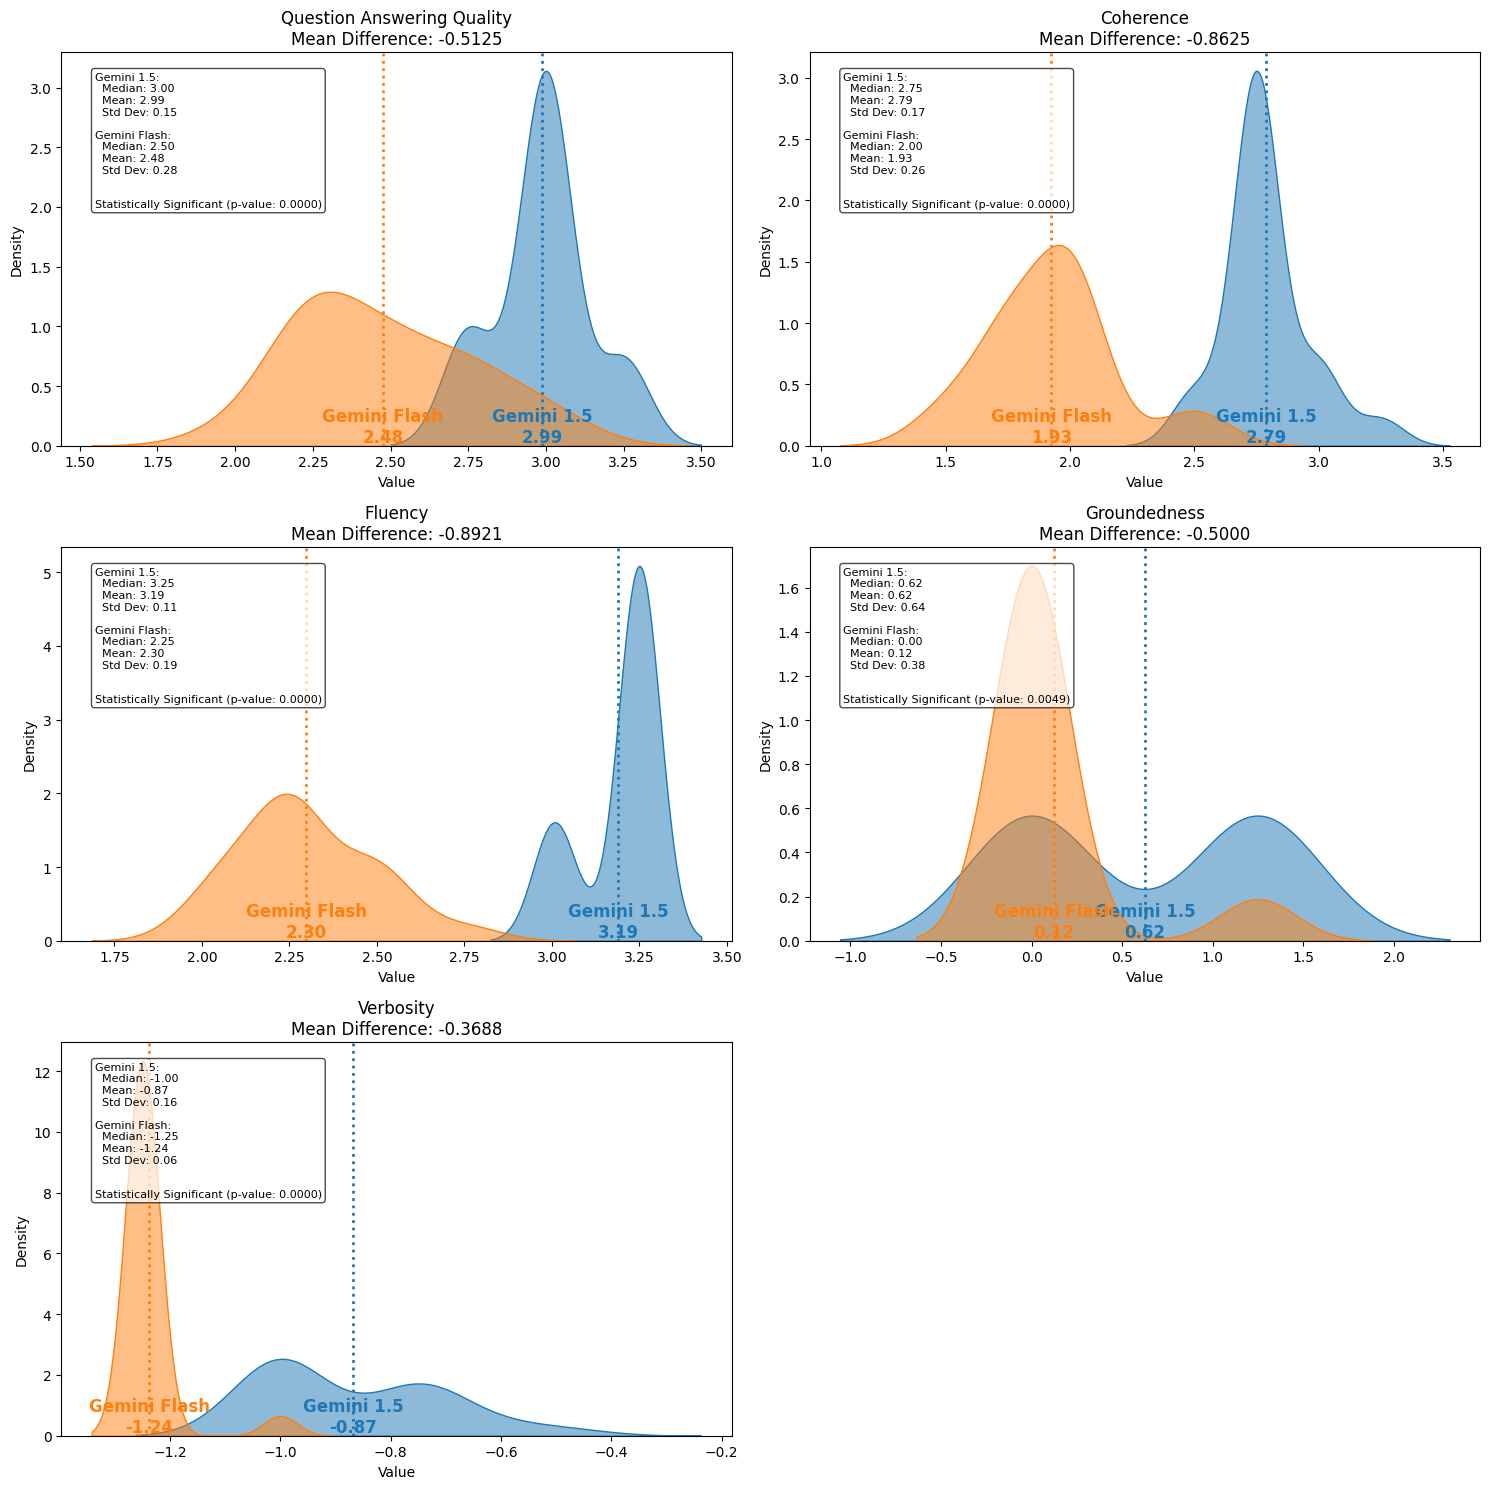

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Sample data
dataframes = [gemini_1_5_results_df, gemini_flash_results_df]
dataframe_names = ["Gemini 1.5", "Gemini Flash"]


# Create KDE plots
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
# Define a color palette
colors = ['#1f77b4', '#ff7f0e']  # You can add more colors if you have more dataframes

for i, metric in enumerate(mean_metrics):
    row, col = i // 2, i % 2

    means = []
    for df, name, color in zip(dataframes, dataframe_names, colors):
        # Plot KDE
        sns.kdeplot(data=df[metric], ax=axs[row, col], fill=True, alpha=0.5, label=name, color=color)

        # Calculate mean and plot dotted line
        mean_value = df[metric].mean()
        means.append(mean_value)
        axs[row, col].axvline(mean_value, color=color, linestyle=':', linewidth=2)

    # Calculate mean difference and perform t-test
    mean_diff = means[1] - means[0]
    t_stat, p_value = stats.ttest_ind(dataframes[0][metric], dataframes[1][metric])

    title = metric.split('/')[0].replace("_", " ").title()
    diff_title = f"{title}\nMean Difference: {mean_diff:.4f}"
    axs[row, col].set_title(diff_title, fontsize=12)
    axs[row, col].set_xlabel('Value')
    axs[row, col].set_ylabel('Density')


    # Add value labels at the bottom
    ylim = axs[row, col].get_ylim()
    for df, name, color, mean in zip(dataframes, dataframe_names, colors, means):
        axs[row, col].text(mean, ylim[0], f'{name}\n{mean:.2f}', color=color,
                           ha='center', va='bottom', fontweight='bold', fontsize=12)

    # Add text annotations
    stats_text = ""
    for df, name in zip(dataframes, dataframe_names):
        median = df[metric].median()
        mean = df[metric].mean()
        std = df[metric].std()
        stats_text += f'{name}:\n  Median: {median:.2f}\n  Mean: {mean:.2f}\n  Std Dev: {std:.2f}\n\n'

    # Add statistical significance information
    if p_value < 0.02:
        sig_text = f"Statistically Significant (p-value: {p_value:.4f})"
    else:
        sig_text = f"Not Statistically Significant (p-value: {p_value:.4f})"

    stats_text += f"\n{sig_text}"

    axs[row, col].text(0.05, 0.95, stats_text,
                       transform=axs[row, col].transAxes, verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.7),
                       fontsize=8)

# Remove extra subplot
if len(metrics) % 2 != 0:
    axs[-1, -1].axis('off')

plt.tight_layout()
plt.show()

**Note:** We can evidence that sometimes the normal distribution is not as clear as other times, that is why is important to look at the charts before making any definitive conclusion

#**Comparing Results**

Now we can plot a more general overlapping view using a radar chart to understand in which areas the approaches differ

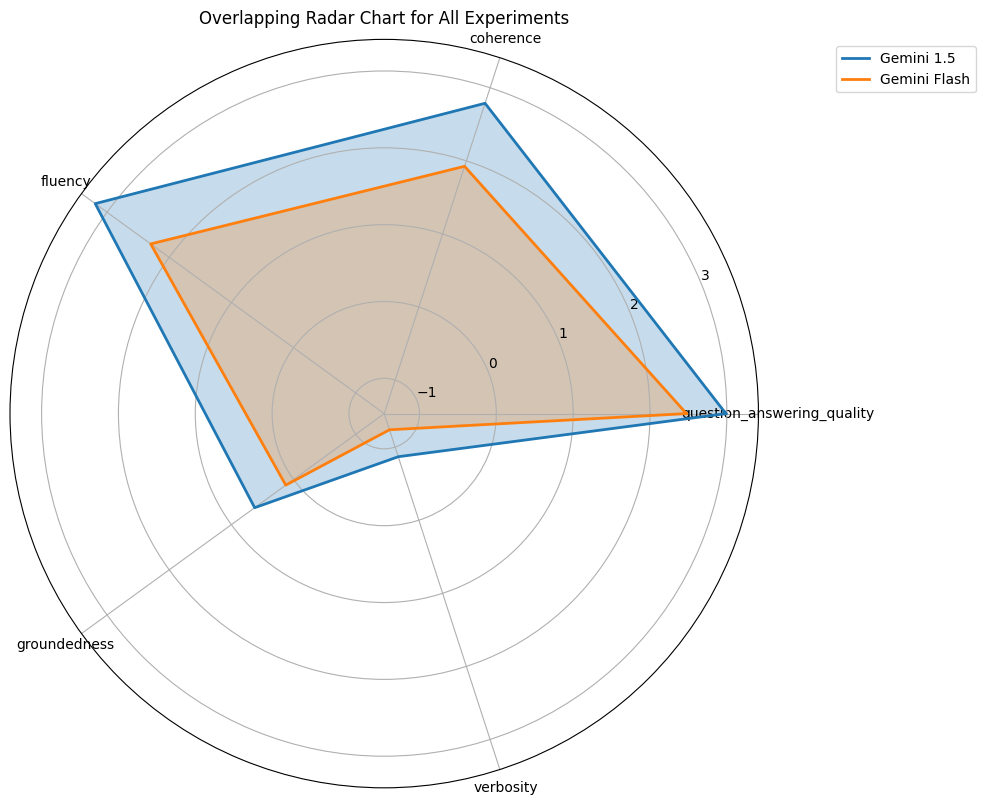

In [ ]:
# Function to create radar chart
def radar_chart(data, title):
    angles = np.linspace(0, 2*np.pi, len(mean_metrics), endpoint=False)
    values = data[mean_metrics].mean().values
    values = np.concatenate((values, [values[0]]))  # repeat the first value to close the polygon
    angles = np.concatenate((angles, [angles[0]]))  # repeat the first angle to close the polygon

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection='polar'))
    ax.plot(angles, values)
    ax.fill(angles, values, alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([m.split('/')[0] for m in mean_metrics], wrap=True)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

# # Create radar charts for each dataframe
# for df, name in zip(dataframes, dataframe_names):
#     radar_chart(df, f'Radar Chart for {name}')

# Create overlapping radar chart
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

angles = np.linspace(0, 2*np.pi, len(mean_metrics), endpoint=False)
angles = np.concatenate((angles, [angles[0]]))  # repeat the first angle to close the polygon

for df, name in zip(dataframes, dataframe_names):
    values = df[mean_metrics].mean().values
    values = np.concatenate((values, [values[0]]))  # repeat the first value to close the polygon
    ax.plot(angles, values, linewidth=2, label=name)
    ax.fill(angles, values, alpha=0.25)

ax.set_xticks(angles[:-1])
ax.set_xticklabels([m.split('/')[0] for m in mean_metrics], wrap=True)
ax.set_title('Overlapping Radar Chart for All Experiments')
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

plt.tight_layout()
plt.show()

## Conclusions

In this notebook, we demonstrated the power of statistical analysis in understanding the performance of non-deterministic eval tasks. By leveraging techniques like the independent samples t-test, we moved beyond single-run observations to gain a more comprehensive understanding of the variability and underlying trends in our results.

The insights gleaned from this analysis can inform future iterations of the eval task, guide decision-making based on statistically sound evidence, and pave the way for more robust and reliable evaluations in the face of inherent uncertainty.

Note: The purpose of this analysis is not to have a rigorous statistical proof (since we are making a lot of assumptions), but to gain a more holistic view of the architecture's performance